BARILLER - BERTRAND - LAHMI

In [2]:
import scipy.optimize
import numpy as np
import matplotlib.pyplot as plt

# Partie I

### Q1.2

In [3]:
def solveOT(mu, nu, C) :
    N = len(mu)
    
    t1 = np.repeat(np.eye(N), N, axis=1)
    t2 = np.hstack([np.eye(N)]*N)
    A = np.vstack((t1, t2))

    b = np.hstack((mu, nu))
    C_line = np.reshape(C, (1, -1))[0]
    bounds = tuple((0, None) for _ in range(N*N))

    res = scipy.optimize.linprog(C_line, A_eq=A, b_eq=b, bounds=bounds, method='simplex')
    assert res.success == True, "linprog status : {}".format(res.status) #verif si linprog a bien convergé
    
    return np.reshape(res.x, (N, N))


### Q1.3

/var/folders/0m/07y4vn414bng8jcy4nv9qj900000gp/T/ipykernel_4400/3319322507.py:12: DeprecationWarning: `method='simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  res = scipy.optimize.linprog(C_line, A_eq=A, b_eq=b, bounds=bounds, method='simplex')
/var/folders/0m/07y4vn414bng8jcy4nv9qj900000gp/T/ipykernel_4400/3319322507.py:12: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  res = scipy.optimize.linprog(C_line, A_eq=A, b_eq=b, bounds=bounds, method='simplex')


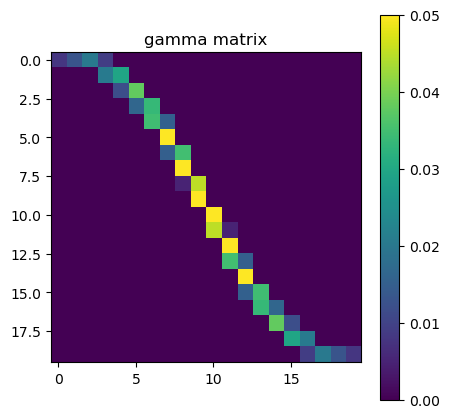

In [4]:
N = 20
xs = np.linspace(0, 1, N)

mu = np.ones(xs.shape)
mu = mu / np.sum(mu)

nu = np.exp(-10 * (xs - 0.5)**2)
nu = nu / np.sum(nu)

xx, yy = np.meshgrid(xs, xs)
C = (xx-yy)**2
# C = (xs[:, np.newaxis] - xs[np.newaxis, :])**2 #other way of calculating distance matrix

gamma = solveOT(mu, nu, C)


#testing if gamma in the sol space of Monge-Kantorovich
assert np.all(gamma >= 0), "there are negative values in gamma"
for i in range(N) :
    np.testing.assert_almost_equal(np.sum(gamma[i, :]), mu[i], err_msg="sum of {}-th line of gamma != mu_{}".format(i, i))
    np.testing.assert_almost_equal(np.sum(gamma[:, i]), nu[i], err_msg="sum of {}-th column of gamma != nu_{}".format(i, i))


# #plotting the solution matrix gamma
fig, ax = plt.subplots(1, 1, figsize=(5,5))
pos = ax.imshow(gamma)
fig.colorbar(pos, ax=ax)
ax.set_title("gamma matrix")
plt.show()

### Q1.5

/var/folders/0m/07y4vn414bng8jcy4nv9qj900000gp/T/ipykernel_4400/3319322507.py:12: DeprecationWarning: `method='simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  res = scipy.optimize.linprog(C_line, A_eq=A, b_eq=b, bounds=bounds, method='simplex')
/var/folders/0m/07y4vn414bng8jcy4nv9qj900000gp/T/ipykernel_4400/3319322507.py:12: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  res = scipy.optimize.linprog(C_line, A_eq=A, b_eq=b, bounds=bounds, method='simplex')


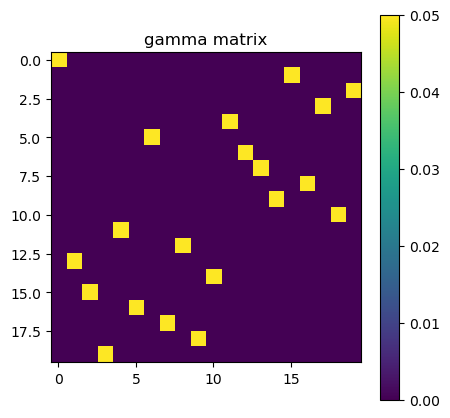

In [5]:
N = 20

xs = np.random.rand(N)
ys = np.random.rand(N)

mu = np.array([1/N]*N)
nu = np.array([1/N]*N)

xx, yy = np.meshgrid(xs, ys)
C = (xx-yy)**2

gamma = solveOT(mu, nu, C)

#plotting the solution matrix gamma
fig, ax = plt.subplots(1, 1, figsize=(5,5))
pos = ax.imshow(gamma)
fig.colorbar(pos, ax=ax)
ax.set_title("gamma matrix")
plt.show()

### Q1.6

/var/folders/0m/07y4vn414bng8jcy4nv9qj900000gp/T/ipykernel_4400/3319322507.py:12: DeprecationWarning: `method='simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  res = scipy.optimize.linprog(C_line, A_eq=A, b_eq=b, bounds=bounds, method='simplex')
/var/folders/0m/07y4vn414bng8jcy4nv9qj900000gp/T/ipykernel_4400/3319322507.py:12: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  res = scipy.optimize.linprog(C_line, A_eq=A, b_eq=b, bounds=bounds, method='simplex')


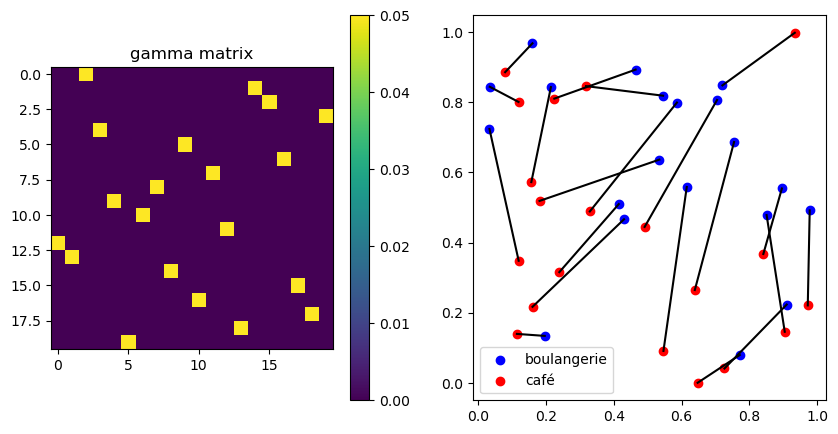

In [6]:
N = 20

xs = np.random.rand(N, 2)
ys = np.random.rand(N, 2)

mu = np.array([1/N]*N)
nu = np.array([1/N]*N)

C = np.sum((xs[:, np.newaxis, :] - ys[np.newaxis, :, :]) ** 2, axis = -1)

gamma = solveOT(mu, nu, C)

#plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

#plotting the solution matrix gamma
pos = ax1.imshow(gamma)
fig.colorbar(pos, ax=ax1)
ax1.set_title("gamma matrix")

#plotting boulangerie/café and "links" 
ax2.scatter(xs[:,0], xs[:,1], c='blue', label='boulangerie')
ax2.scatter(ys[:,0], ys[:,1], c='red', label='café')
for i, j in zip(np.nonzero(gamma)[0], np.nonzero(gamma)[1]) :
    ax2.plot((xs[i,0], ys[j,0]), (xs[i,1], ys[j,1]), color='black')
ax2.legend()

plt.show()

# Partie II

### Q2.3

In [7]:
def GradDualReg(mu, nu, C, eps, tau, max_iter=2000) :
    N = len(mu)
    
    u = np.zeros(N)
    for _ in range(max_iter) :
        grads_f_eps = np.array([np.exp((u - C[:, j])/eps) for j in range(N)])
        old = grads_f_eps
        grads_f_eps = grads_f_eps / np.sum(grads_f_eps, axis=1)[:, np.newaxis]
        d = mu - np.sum(grads_f_eps * nu[:, np.newaxis], axis=0)
        u = u + tau*d

    v = np.array([np.min([C[i, j] - u[i] for i in range(N)]) for j in range(N)])

    return u, v

### Q2.4

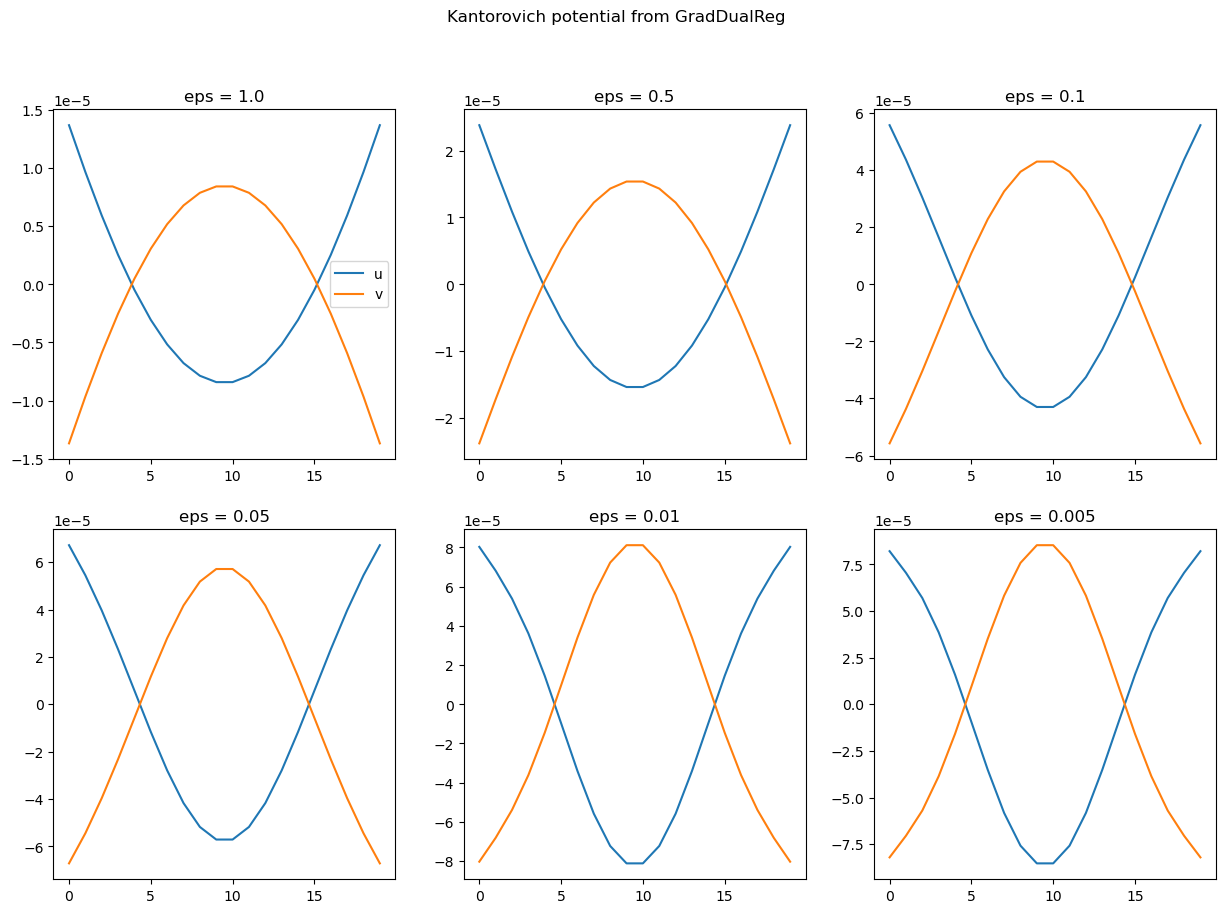

In [8]:
N = 20
xs = np.linspace(0, 1, N)

mu = np.ones(xs.shape)
mu = mu / np.sum(mu)

nu = np.exp(-10 * (xs - 0.5)**2)
nu = nu / np.sum(nu)

xx, yy = np.meshgrid(xs, xs)
C = (xx-yy)**2
# C = (xs[:, np.newaxis] - xs[np.newaxis, :])**2 #other way of calculating distance matrix


tau = 1e-6
eps = np.array([1, 0.5, 0.1, 0.05, 0.01, 0.005]).reshape(2,3)

#plotting
fig, axs = plt.subplots(2, 3, figsize=(15,10))

fig.suptitle("Kantorovich potential from GradDualReg")
for (i, j), e in np.ndenumerate(eps) : 
    ax = axs[i][j]

    u, v = GradDualReg(mu, nu, C, e, tau)
    ax.set_title("eps = {}".format(e))
    ax.plot(u, label="u")
    ax.plot(v, label="v")
    if i == j == 0 : ax.legend()

plt.show()


# Partie III

### Q3.3

In [9]:
def EntDual(mu, nu, C, eps, tau=1e-3, max_iter=2000) :
    N = len(mu)
    u = np.zeros(N)
    v = np.zeros(N)
    # uv = np.zeros(2*N)

    gamma_bar = np.exp(-C / eps)

    for _ in range(max_iter) :
        a = np.exp(u / eps)
        b = np.exp(v / eps)
        part_grad_u = (gamma_bar @ b)*a
        part_grad_v = (gamma_bar.T @ a)*b
        grad_u = part_grad_u - mu
        grad_v = part_grad_v - nu

        u = u - tau*grad_u
        v = v - tau*grad_v

    a = np.exp(u / eps)
    b = np.exp(v / eps)

    aa, bb = np.meshgrid(a, b, indexing='ij')
    gamma = aa*bb*gamma_bar

    return u, v, gamma



### Q3.4

/var/folders/0m/07y4vn414bng8jcy4nv9qj900000gp/T/ipykernel_4400/3319322507.py:12: DeprecationWarning: `method='simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  res = scipy.optimize.linprog(C_line, A_eq=A, b_eq=b, bounds=bounds, method='simplex')
/var/folders/0m/07y4vn414bng8jcy4nv9qj900000gp/T/ipykernel_4400/3319322507.py:12: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  res = scipy.optimize.linprog(C_line, A_eq=A, b_eq=b, bounds=bounds, method='simplex')


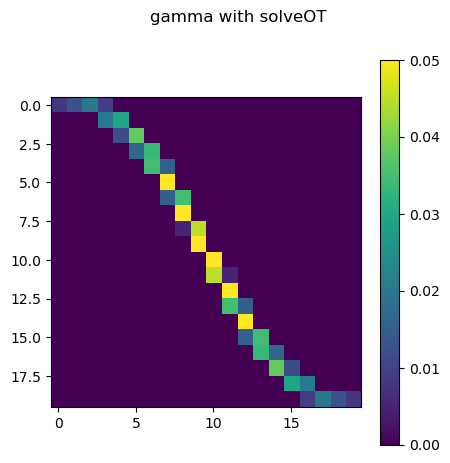

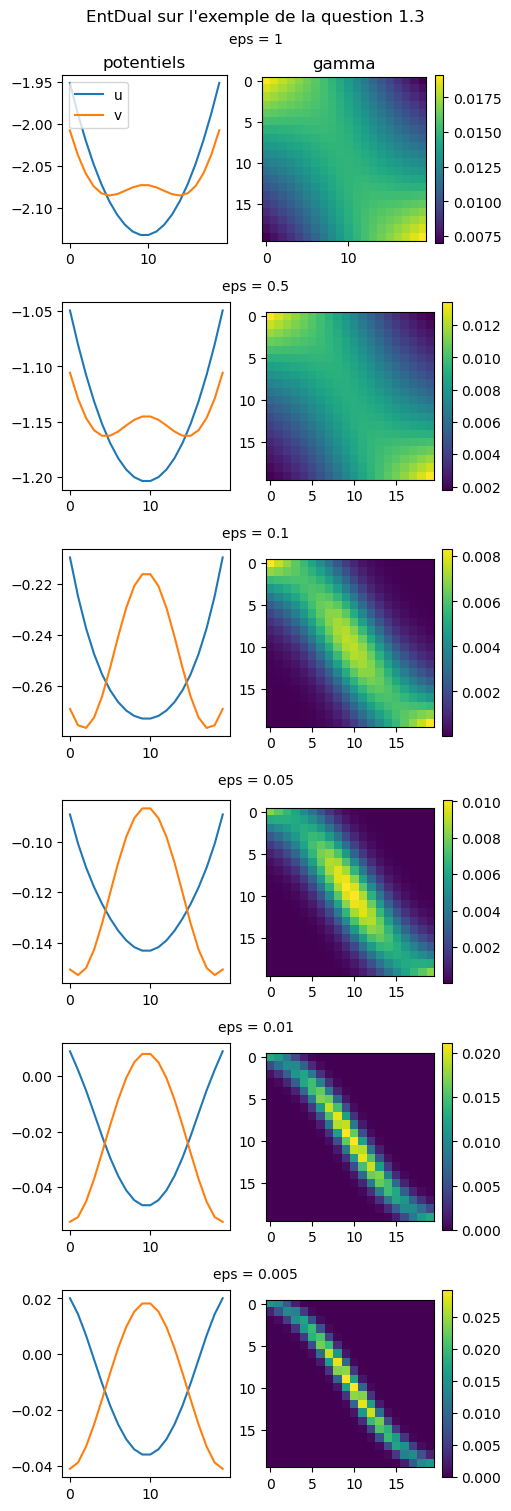

In [10]:
N = 20
xs = np.linspace(0, 1, N)

mu = np.ones(xs.shape)
mu = mu / np.sum(mu)

nu = np.exp(-10 * (xs - 0.5)**2)
nu = nu / np.sum(nu)

xx, yy = np.meshgrid(xs, xs)
C = (xx-yy)**2


tau = 1e-3
max_iter = 2000
eps = [1, 0.5, 0.1, 0.05, 0.01, 0.005]

#plotting
#matrix with solveOT
fig, ax = plt.subplots(1, 1, figsize = (5,5))

gamma = solveOT(mu, nu, C)
pos = ax.imshow(gamma)
fig.colorbar(pos, ax=ax)
fig.suptitle("gamma with solveOT")
plt.show()


#matrix and potentials with EntDual

# create 6x1 subplots
fig, axs = plt.subplots(len(eps), 1, figsize=(5,len(eps)/2 * 5), constrained_layout=True)
fig.suptitle("EntDual sur l'exemple de la question 1.3")

# clear subplots
for ax in axs:
    ax.remove()

# add subfigure per subplot
gridspec = axs[0].get_subplotspec().get_gridspec()
subfigs = [fig.add_subfigure(gs) for gs in gridspec]

for i, subfig in enumerate(subfigs):
    subfig.suptitle("eps = {}".format(eps[i]), fontsize=10)

    # create 1x2 subplots per subfig
    ax1, ax2 = subfig.subplots(nrows=1, ncols=2)

    u, v, gamma = EntDual(mu, nu, C, eps[i], tau=tau, max_iter=max_iter)

    ax1.plot(u, label="u")
    ax1.plot(v, label="v")
    
    pos = ax2.imshow(gamma)
    fig.colorbar(pos, ax=ax2)

    if i == 0 :
        ax1.legend(loc="upper left")
        ax1.set_title("potentiels")

        ax2.set_title("gamma")

plt.show()


/var/folders/0m/07y4vn414bng8jcy4nv9qj900000gp/T/ipykernel_4400/3319322507.py:12: DeprecationWarning: `method='simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  res = scipy.optimize.linprog(C_line, A_eq=A, b_eq=b, bounds=bounds, method='simplex')
/var/folders/0m/07y4vn414bng8jcy4nv9qj900000gp/T/ipykernel_4400/3319322507.py:12: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  res = scipy.optimize.linprog(C_line, A_eq=A, b_eq=b, bounds=bounds, method='simplex')


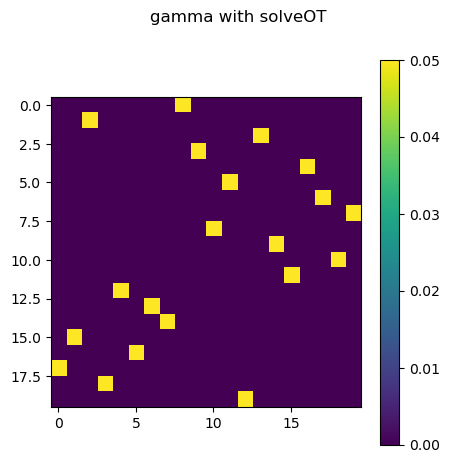

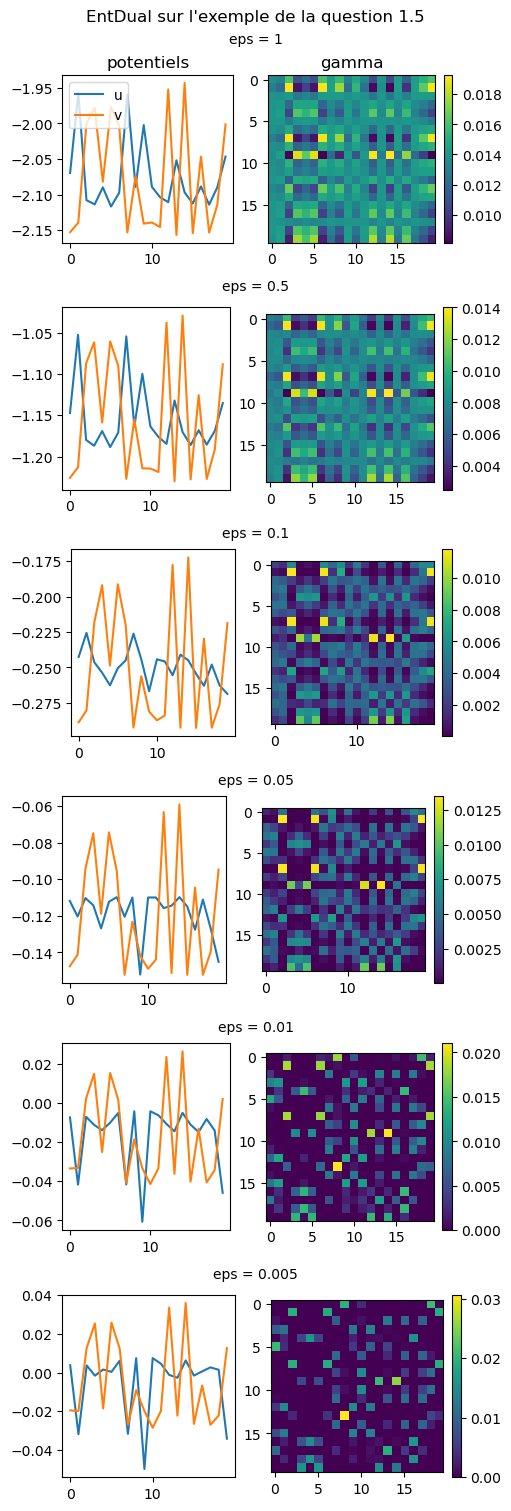

In [11]:
N = 20

xs = np.random.rand(N)
ys = np.random.rand(N)

mu = np.array([1/N]*N)
nu = np.array([1/N]*N)

xx, yy = np.meshgrid(xs, ys)
C = (xx-yy)**2


tau = 1e-3
max_iter = 2000
eps = [1, 0.5, 0.1, 0.05, 0.01, 0.005]

#plotting
#matrix with solveOT
fig, ax = plt.subplots(1, 1, figsize = (5,5))

gamma = solveOT(mu, nu, C)
pos = ax.imshow(gamma)
fig.colorbar(pos, ax=ax)
fig.suptitle("gamma with solveOT")
plt.show()


#matrix and potentials with EntDual

# create 6x1 subplots
fig, axs = plt.subplots(len(eps), 1, figsize=(5,len(eps)/2 * 5), constrained_layout=True)
fig.suptitle("EntDual sur l'exemple de la question 1.5")

# clear subplots
for ax in axs:
    ax.remove()

# add subfigure per subplot
gridspec = axs[0].get_subplotspec().get_gridspec()
subfigs = [fig.add_subfigure(gs) for gs in gridspec]

for i, subfig in enumerate(subfigs):
    subfig.suptitle("eps = {}".format(eps[i]), fontsize=10)

    # create 1x2 subplots per subfig
    ax1, ax2 = subfig.subplots(nrows=1, ncols=2)

    u, v, gamma = EntDual(mu, nu, C, eps[i], tau=tau, max_iter=max_iter)

    ax1.plot(u, label="u")
    ax1.plot(v, label="v")
    
    pos = ax2.imshow(gamma)
    fig.colorbar(pos, ax=ax2)

    if i == 0 :
        ax1.legend(loc="upper left")
        ax1.set_title("potentiels")

        ax2.set_title("gamma")

plt.show()


### Q3.5

In [12]:
def Sinkhorn(mu, nu, C, eps, err_break=1e-3, max_iter=2000) :
    """
    @Param :
        - mu, nu: distributions sur les espaces de départ et d'arrivé
                    -> 1d array de même taille N
        - C     : la matrice de coût
                    -> 2d array de taille (N,N)
        - eps   : est le paramètre de régularisation 
                    -> float 

    @Return :
        - u et v: les potentiels de Kantorovich du problème avec régularisation entropique
                    -> 1d array de taille N
        - gamma : la matrice de couplage optimal associée à u et v
                    -> 2d array de taille (N,N)

    @Param Opt :
        - err_break : paramètre d'erreur pour arrêter l'algorithme
                        -> float
        - max_iter  : le nombre d'itération maximum de l'algorithme
                        -> int
    """
    N = len(mu)

    gamma_bar = np.exp(-C / eps)

    # a = np.random.rand(N)
    # b = np.random.rand(N)
    a = np.ones(N)
    b = np.ones(N)

    do_break = False
    for _ in range(max_iter) :
        a_new = mu / np.sum(b * gamma_bar, axis=1)
        b_new = nu / np.sum((a_new * gamma_bar.T).T, axis=0)

        if max(np.linalg.norm(a_new - a), np.linalg.norm(b_new-b)) < err_break :
            do_break = True

        a = a_new
        b = b_new
        
        if do_break : break

    if not do_break : print("Warning : ended after max_iter, not err_break.")    

    u = eps * np.log(a)
    v = eps * np.log(b)

    aa, bb = np.meshgrid(a, b, indexing='ij')
    gamma = aa*bb*gamma_bar

    return u, v, gamma


/var/folders/0m/07y4vn414bng8jcy4nv9qj900000gp/T/ipykernel_4400/3319322507.py:12: DeprecationWarning: `method='simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  res = scipy.optimize.linprog(C_line, A_eq=A, b_eq=b, bounds=bounds, method='simplex')
/var/folders/0m/07y4vn414bng8jcy4nv9qj900000gp/T/ipykernel_4400/3319322507.py:12: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  res = scipy.optimize.linprog(C_line, A_eq=A, b_eq=b, bounds=bounds, method='simplex')


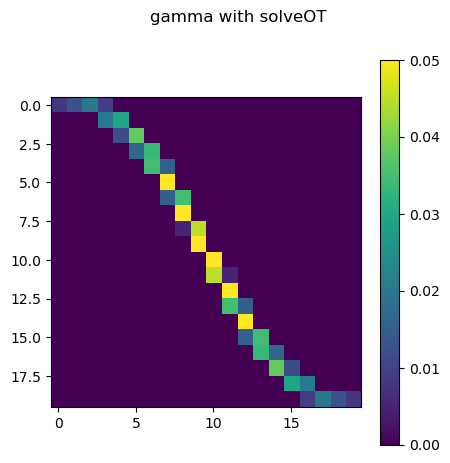

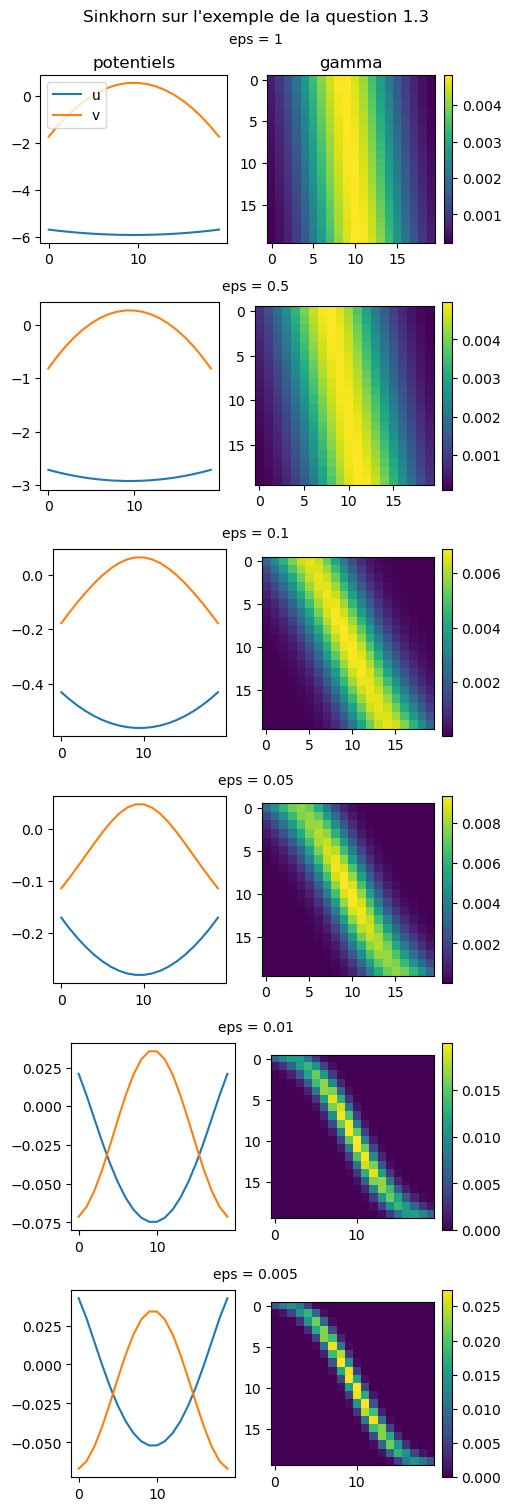

In [13]:
N = 20
xs = np.linspace(0, 1, N)

mu = np.ones(xs.shape)
mu = mu / np.sum(mu)

nu = np.exp(-10 * (xs - 0.5)**2)
nu = nu / np.sum(nu)

xx, yy = np.meshgrid(xs, xs)
C = (xx-yy)**2


err_break = 1e-3
max_iter = 2000
eps = [1, 0.5, 0.1, 0.05, 0.01, 0.005]

#plotting
#matrix with solveOT
fig, ax = plt.subplots(1, 1, figsize = (5,5))

gamma = solveOT(mu, nu, C)
pos = ax.imshow(gamma)
fig.colorbar(pos, ax=ax)
fig.suptitle("gamma with solveOT")
plt.show()


#matrix and potentials with EntDual

# create 6x1 subplots
fig, axs = plt.subplots(len(eps), 1, figsize=(5,len(eps)/2 * 5), constrained_layout=True)
fig.suptitle("Sinkhorn sur l'exemple de la question 1.3")

# clear subplots
for ax in axs:
    ax.remove()

# add subfigure per subplot
gridspec = axs[0].get_subplotspec().get_gridspec()
subfigs = [fig.add_subfigure(gs) for gs in gridspec]

for i, subfig in enumerate(subfigs):
    subfig.suptitle("eps = {}".format(eps[i]), fontsize=10)

    # create 1x2 subplots per subfig
    ax1, ax2 = subfig.subplots(nrows=1, ncols=2)

    u, v, gamma = Sinkhorn(mu, nu, C, eps[i], err_break=err_break, max_iter=max_iter)

    ax1.plot(u, label="u")
    ax1.plot(v, label="v")
    
    pos = ax2.imshow(gamma)
    fig.colorbar(pos, ax=ax2)

    if i == 0 :
        ax1.legend(loc="upper left")
        ax1.set_title("potentiels")

        ax2.set_title("gamma")

plt.show()


/var/folders/0m/07y4vn414bng8jcy4nv9qj900000gp/T/ipykernel_4400/3319322507.py:12: DeprecationWarning: `method='simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  res = scipy.optimize.linprog(C_line, A_eq=A, b_eq=b, bounds=bounds, method='simplex')
/var/folders/0m/07y4vn414bng8jcy4nv9qj900000gp/T/ipykernel_4400/3319322507.py:12: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  res = scipy.optimize.linprog(C_line, A_eq=A, b_eq=b, bounds=bounds, method='simplex')


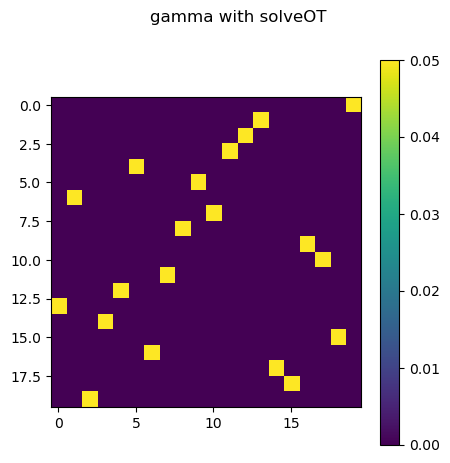

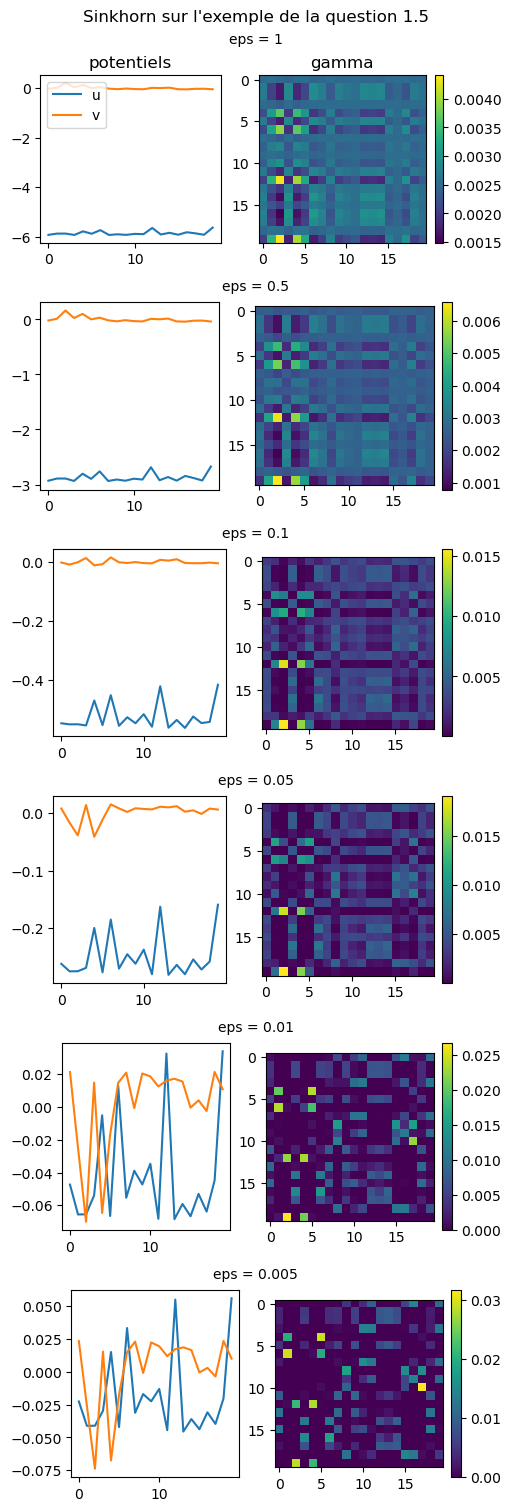

In [14]:
N = 20

xs = np.random.rand(N)
ys = np.random.rand(N)

mu = np.array([1/N]*N)
nu = np.array([1/N]*N)

xx, yy = np.meshgrid(xs, ys)
C = (xx-yy)**2


err_break = 1e-3
max_iter = 2000
eps = [1, 0.5, 0.1, 0.05, 0.01, 0.005]

#plotting
#matrix with solveOT
fig, ax = plt.subplots(1, 1, figsize = (5,5))

gamma = solveOT(mu, nu, C)
pos = ax.imshow(gamma)
fig.colorbar(pos, ax=ax)
fig.suptitle("gamma with solveOT")
plt.show()


#matrix and potentials with EntDual

# create 6x1 subplots
fig, axs = plt.subplots(len(eps), 1, figsize=(5,len(eps)/2 * 5), constrained_layout=True)
fig.suptitle("Sinkhorn sur l'exemple de la question 1.5")

# clear subplots
for ax in axs:
    ax.remove()

# add subfigure per subplot
gridspec = axs[0].get_subplotspec().get_gridspec()
subfigs = [fig.add_subfigure(gs) for gs in gridspec]

for i, subfig in enumerate(subfigs):
    subfig.suptitle("eps = {}".format(eps[i]), fontsize=10)

    # create 1x2 subplots per subfig
    ax1, ax2 = subfig.subplots(nrows=1, ncols=2)

    u, v, gamma = Sinkhorn(mu, nu, C, eps[i], err_break=err_break, max_iter=max_iter)

    ax1.plot(u, label="u")
    ax1.plot(v, label="v")
    
    pos = ax2.imshow(gamma)
    fig.colorbar(pos, ax=ax2)

    if i == 0 :
        ax1.legend(loc="upper left")
        ax1.set_title("potentiels")

        ax2.set_title("gamma")

plt.show()


# Partie IV

### Q4.2

In [15]:
def Sinkhorn2d(mu, nu, C, eps, err_break=1e-3, max_iter=2000) :
    """
    @Param :
        - mu, nu: distributions sur les espaces de départ et d'arrivé
                    -> 1d array de taille n et m
        - C     : la matrice de coût
                    -> 2d array de taille (n,m)
        - eps   : paramètre de régularisation 
                    -> float 

    @Return :
        - u et v: potentiels de Kantorovich du problème avec régularisation entropique
                    -> 1d array de taille n et m
        - gamma : matrice de couplage optimal associée à u et v
                    -> 2d array de taille (n,m)

    @Param Opt :
        - err_break : paramètre d'erreur pour arrêter l'algorithme
                        -> float
        - max_iter  : le nombre d'itération maximum de l'algorithme
                        -> int
    """
    n = len(mu)
    m = len(nu)
    
    gamma_bar = np.exp(-C / eps)

    a = np.ones(n)
    b = np.ones(m)

    do_break = False
    for _ in range(max_iter) :
        a_new = mu / np.sum(b * gamma_bar, axis=1)
        b_new = nu / np.sum((a_new * gamma_bar.T).T, axis=0)

        if max(np.linalg.norm(a_new - a), np.linalg.norm(b_new-b)) < err_break :
            do_break = True

        a = a_new
        b = b_new
        
        if do_break : break

    # if not do_break : print("Warning : ended after max_iter, not err_break.")    

    u = eps * np.log(a)
    v = eps * np.log(b)

    aa, bb = np.meshgrid(a, b, indexing='ij')
    gamma = aa*bb*gamma_bar

    return u, v, gamma


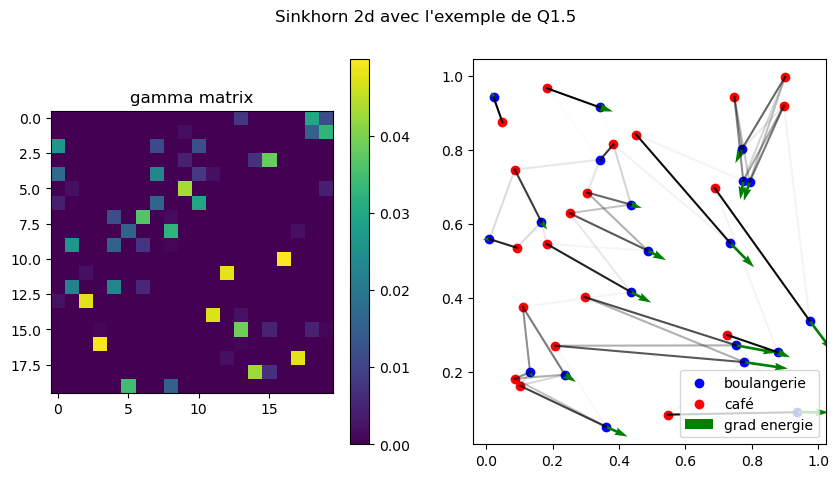

In [16]:
N = 20

xs = np.random.rand(N, 2)
ys = np.random.rand(N, 2)

mu = np.array([1/N]*N)
nu = np.array([1/N]*N)

C = np.sum((xs[:, np.newaxis, :] - ys[np.newaxis, :, :]) ** 2, axis = -1)

u, v, gamma = Sinkhorn2d(mu, nu, C, 0.005, max_iter=int(2e3))

grad_energie = lambda z, y : z - (gamma @ y.T).T / mu
grad = grad_energie(xs.T, ys.T)


# use to fix alpha factor of links between points
gamma_regul = np.sum(gamma, axis=1)


#plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle("Sinkhorn 2d avec l'exemple de Q1.5")

#plotting the solution matrix gamma
pos = ax1.imshow(gamma)
fig.colorbar(pos, ax=ax1)
ax1.set_title("gamma matrix")

#plotting boulangerie/café and gamma 
ax2.scatter(xs[:,0], xs[:,1], c='blue', label='boulangerie')
ax2.scatter(ys[:,0], ys[:,1], c='red', label='café')
for i, j in zip(np.nonzero(gamma)[0], np.nonzero(gamma)[1]) :
    ax2.plot((xs[i,0], ys[j,0]), (xs[i,1], ys[j,1]), color='black', alpha=gamma[i,j]/gamma_regul[i])
ax2.quiver(xs[:,0], xs[:,1], grad[0, :], grad[1, :], color='g', label='grad energie')
ax2.legend()

plt.show()

### Q4.3

In [17]:
def GradWas(z0, y, mu, nu, tau=0.1,  eps=0.005, iter=5, method="Sinkhorn2d") :
    
    z = z0
    for i in range(iter) :
        C = np.sum((y.T[:, np.newaxis, :] - z.T[np.newaxis, :, :]) ** 2, axis = -1).T
        if method == "Sinkhorn2d" :
            _, _, gamma = Sinkhorn2d(mu, nu, C, eps)
        elif method == "EntDual" :
            gamma = EntDual(mu, nu, C, eps)
        else : 
            raise NotImplementedError("{} not implemented for GradWas")

        grad_energie = z - (gamma @ y.T).T / mu
        z = z - tau*grad_energie

    return z



In [18]:
# N = 3
# z = np.vstack([(i, i) for i in range(N)]).T
# y = np.vstack([(0, i) for i in range(N)]).T
# assert np.all(np.sum((y.T[:, np.newaxis, :] - z.T[np.newaxis, :, :]) ** 2, axis = -1) == np.sum((z.T[:, np.newaxis, :] - y.T[np.newaxis, :, :]) ** 2, axis = -1).T)
# y, z, np.sum((z.T[:, np.newaxis, :] - y.T[np.newaxis, :, :]) ** 2, axis = -1), np.sum((y.T[:, np.newaxis, :] - z.T[np.newaxis, :, :]) ** 2, axis = -1)

### Q4.4

In [19]:
n = m = N = 100

z0 = np.random.rand(2, N) - 0.5

theta = 2*np.pi*np.random.rand(1, N)
r = .8 + .2*np.random.rand(1,N)
y = np.vstack((np.cos(theta)*r, np.sin(theta)*r)) 


mu = np.array([1/N]*N)
nu = np.array([1/N]*N)

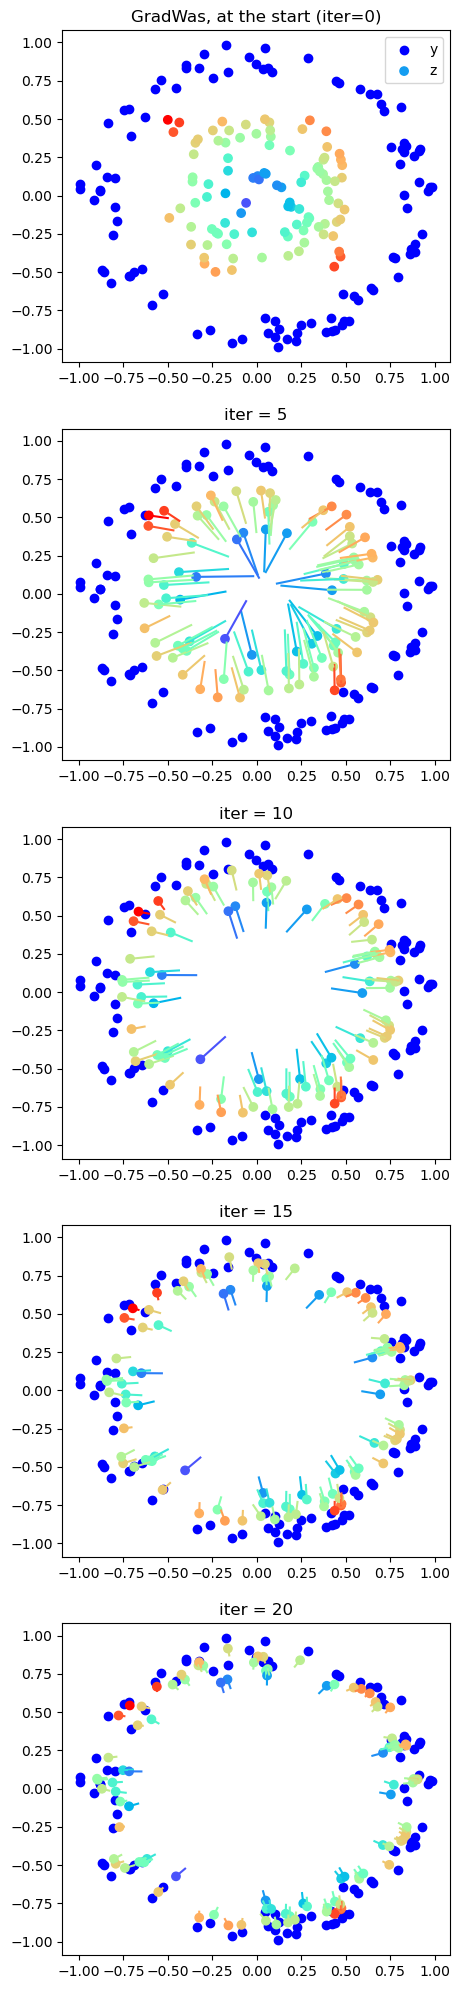

In [20]:
# pretty color for points
norm = np.linalg.norm(z0, axis=0)
colors = plt.cm.rainbow(norm / np.max(norm))


#params
nb_pas = 4
tau = 0.1
eps = 0.005


fig, axs = plt.subplots(nb_pas+1, 1, figsize=(5,5*(nb_pas+1)))


axs[0].set_title("GradWas, at the start (iter=0)")
axs[0].scatter(y[0,:], y[1,:], c='blue', label="y")
axs[0].scatter(z0[0,:], z0[1,:], c = colors, label="z")
axs[0].legend()

z_old = z0
for i in range(1, nb_pas+1) :
    ax = axs[i]

    z = GradWas(z_old, y, mu, nu, tau=tau, eps=eps, iter=5, method="Sinkhorn2d")

    ax.set_title("iter = {}".format(i*5))
    ax.scatter(y[0,:], y[1,:], c='blue')
    ax.scatter(z[0,:], z[1,:], c = colors)
    for i in range(N) :
        ax.plot([z_old[0, i], z[0,i]], [z_old[1, i], z[1,i]], color=colors[i])
    z_old = z


### Q4.5

In [21]:
n, m = 100, 200

z0 = np.random.rand(2, n) - 0.5
mu = np.array([1/n]*n)

theta = 2*np.pi*np.random.rand(1, m)
r = .8 + .2*np.random.rand(1,m)

y = np.vstack((np.cos(theta)*r, np.sin(theta)*r)) 
nu = np.array([1/m]*m)

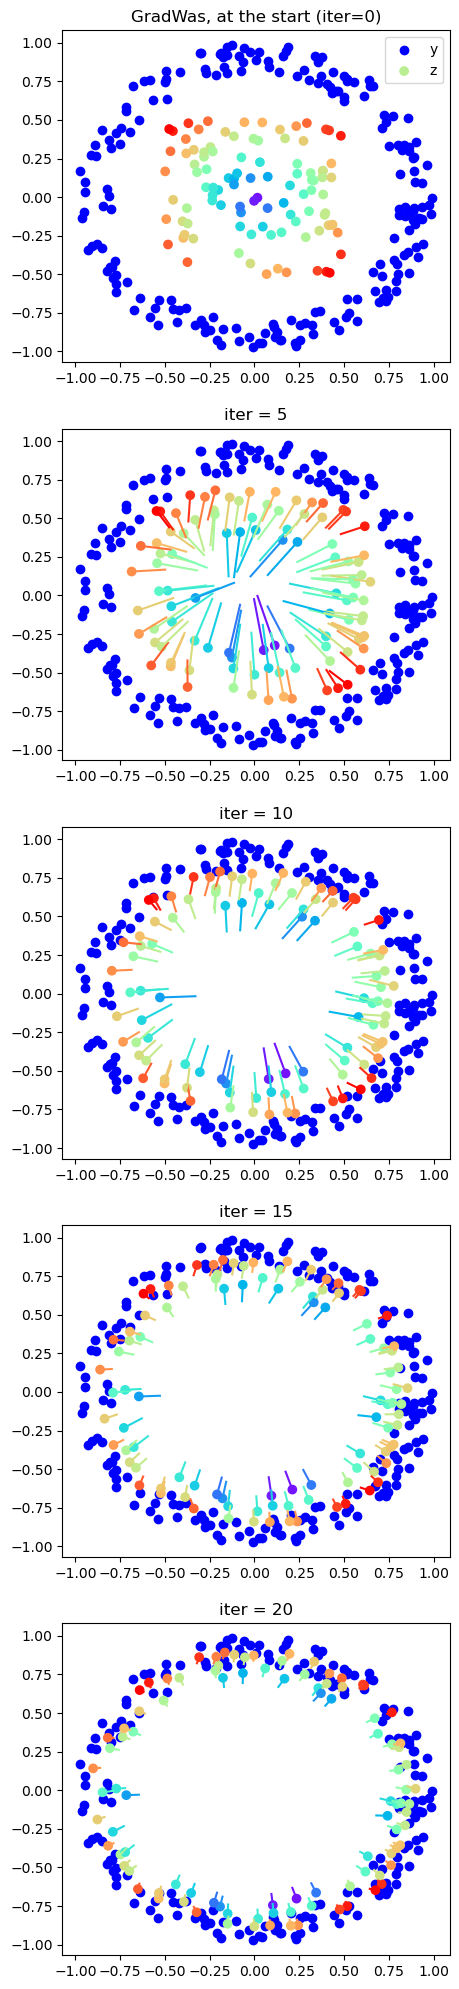

In [22]:
# pretty color for points
norm = np.linalg.norm(z0, axis=0)
colors = plt.cm.rainbow(norm / np.max(norm))


#params
nb_pas = 4
tau = 0.1
eps = 0.005

fig, axs = plt.subplots(nb_pas+1, 1, figsize=(5,5*(nb_pas+1)))


axs[0].set_title("GradWas, at the start (iter=0)")
axs[0].scatter(y[0,:], y[1,:], c='blue', label="y")
axs[0].scatter(z0[0,:], z0[1,:], c = colors, label="z")
axs[0].legend()

z_old = z0
for i in range(1, nb_pas+1) :
    ax = axs[i]

    z = GradWas(z_old, y, mu, nu, tau=tau, eps=eps, iter=5, method="Sinkhorn2d")

    ax.set_title("iter = {}".format(i*5))
    ax.scatter(y[0,:], y[1,:], c='blue')
    ax.scatter(z[0,:], z[1,:], c = colors)
    for i in range(N) :
        ax.plot([z_old[0, i], z[0,i]], [z_old[1, i], z[1,i]], color=colors[i])
    z_old = z


### Q4.6

In [23]:
n, m = 100, 200

z0 = np.random.rand(2, n) - 0.5
mu = np.array([1/n]*n)

theta = 2*np.pi*np.random.rand(1, m)
r = .8 + .2*np.random.rand(1,m)

y = np.vstack((np.cos(theta)*r, np.sin(theta)*r)) 
nu = np.array([1/m]*m)

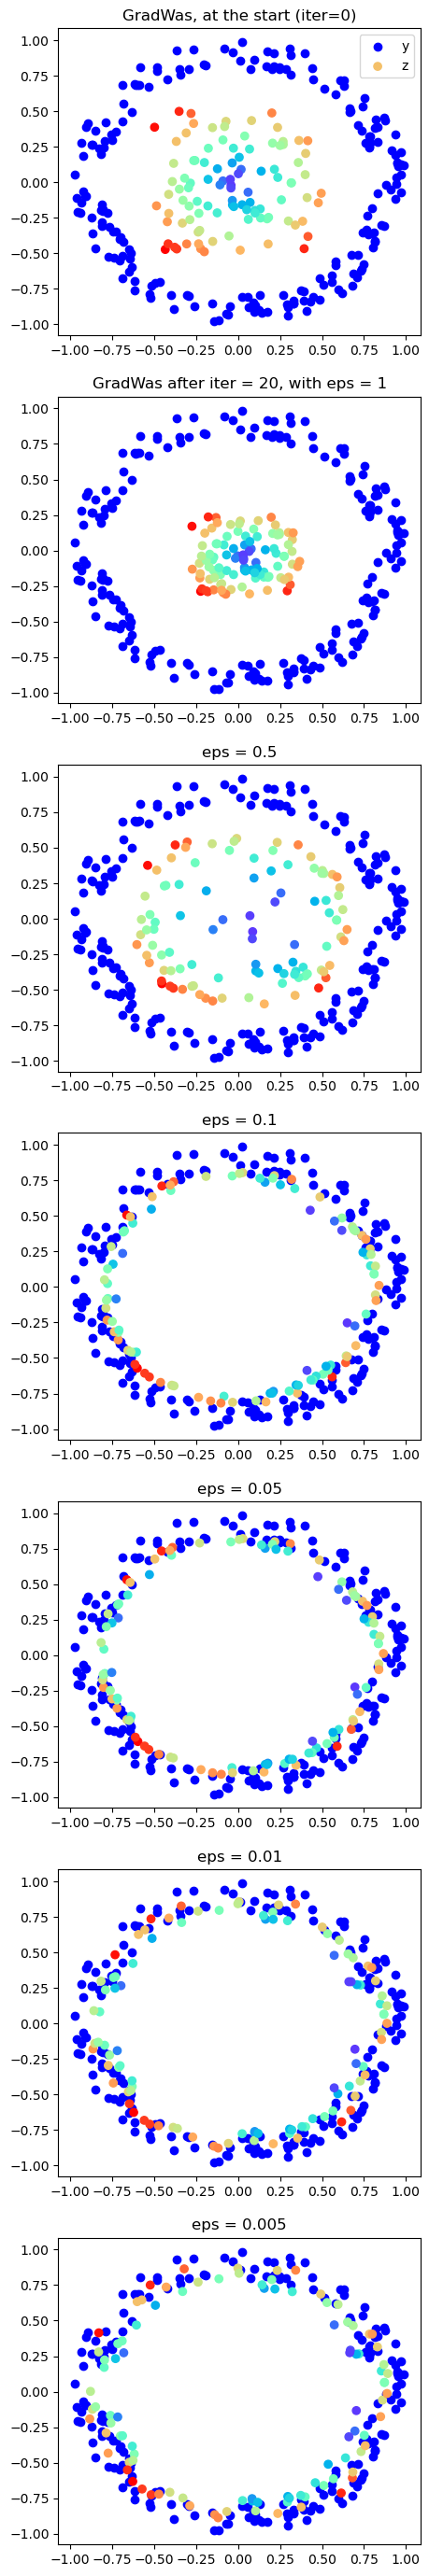

In [24]:
# pretty color for points
norm = np.linalg.norm(z0, axis=0)
colors = plt.cm.rainbow(norm / np.max(norm))


#params
tau = 0.1
eps = [1, 0.5, 0.1, 0.05, 0.01, 0.005]

fig, axs = plt.subplots(len(eps)+1, 1, figsize=(5,5*(len(eps)+1)))


axs[0].set_title("GradWas, at the start (iter=0)")
axs[0].scatter(y[0,:], y[1,:], c='blue', label="y")
axs[0].scatter(z0[0,:], z0[1,:], c = colors, label="z")
axs[0].legend()

for i, e in enumerate(eps) :
    ax = axs[i+1]

    z = GradWas(z0, y, mu, nu, tau=tau, eps=e, iter=20, method="Sinkhorn2d")

    if i == 0 :
        ax.set_title("GradWas after iter = 20, with eps = {}".format(e))
    else :
        ax.set_title("eps = {}".format(e))

    ax.scatter(y[0,:], y[1,:], c='blue')
    ax.scatter(z[0,:], z[1,:], c = colors)


### Q4.7

In [25]:
def GradWasDiv(z0, y, mu, nu, tau=0.1,  eps=0.005, iter=5, method="Sinkhorn2d") :

    z = z0
    for i in range(iter) :
        C = np.sum((y.T[:, np.newaxis, :] - z.T[np.newaxis, :, :]) ** 2, axis = -1).T
        C2 = np.sum((z.T[:, np.newaxis, :] - z.T[np.newaxis, :, :]) ** 2, axis = -1).T
        if method == "Sinkhorn2d" :
            _, _, gamma = Sinkhorn2d(mu, nu, C, eps)
            _, _, gamma2 = Sinkhorn2d(mu, mu, C2, eps)
        elif method == "EntDual" :
            gamma = EntDual(mu, nu, C, eps)
            gamma2 = EntDual(mu, mu, C2, eps)
        else : 
            raise NotImplementedError("{} not implemented for GradWas")

        grad_energie_1 = z - (gamma @ y.T).T / mu
        grad_energie_2 = 1/2*( z - (gamma2 @ z.T).T / mu)
        z = z - tau*(grad_energie_1 - grad_energie_2)

    return z



In [26]:
n, m = 100, 200

z0 = np.random.rand(2, n) - 0.5
mu = np.array([1/n]*n)

theta = 2*np.pi*np.random.rand(1, m)
r = .8 + .2*np.random.rand(1,m)

y = np.vstack((np.cos(theta)*r, np.sin(theta)*r)) 
nu = np.array([1/m]*m)

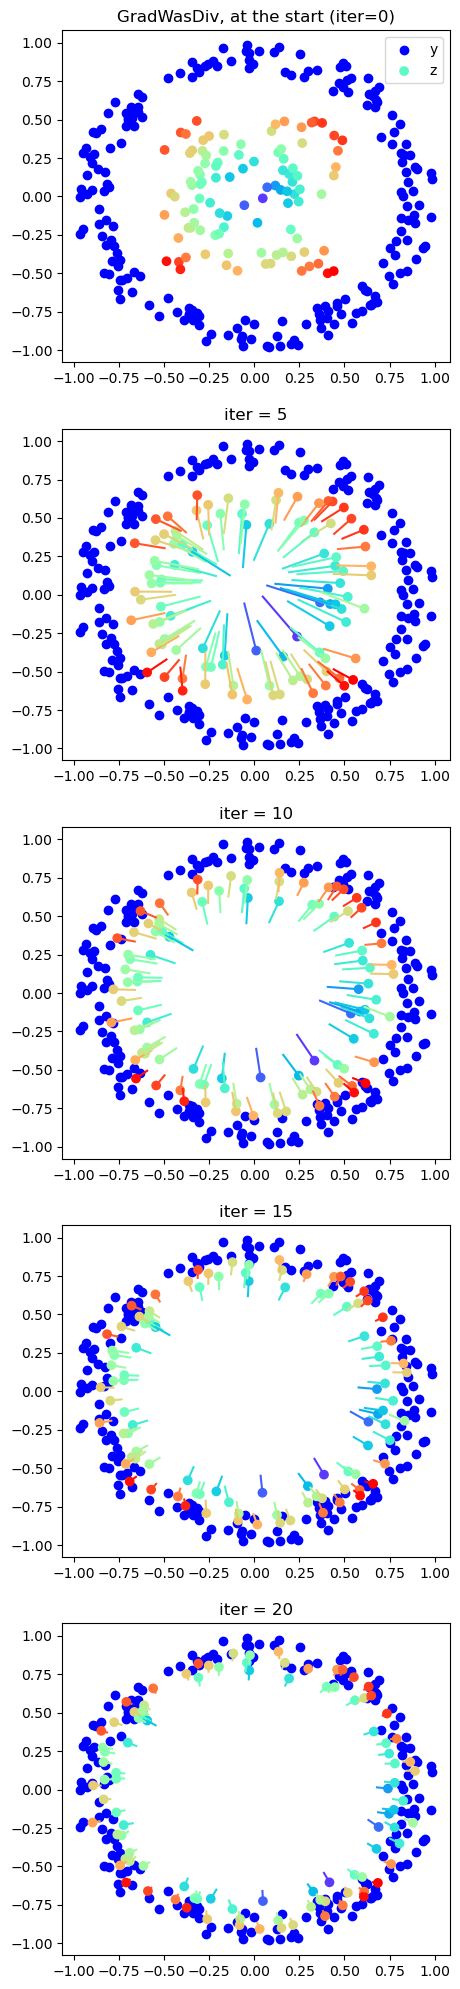

In [27]:
# pretty color for points
norm = np.linalg.norm(z0, axis=0)
colors = plt.cm.rainbow(norm / np.max(norm))


#params
nb_pas = 4
tau = 0.1
eps = 0.005

fig, axs = plt.subplots(nb_pas+1, 1, figsize=(5,5*(nb_pas+1)))


axs[0].set_title("GradWasDiv, at the start (iter=0)")
axs[0].scatter(y[0,:], y[1,:], c='blue', label="y")
axs[0].scatter(z0[0,:], z0[1,:], c = colors, label="z")
axs[0].legend()

z_old = z0
for i in range(1, nb_pas+1) :
    ax = axs[i]

    z = GradWasDiv(z_old, y, mu, nu, tau=tau, eps=eps, iter=5, method="Sinkhorn2d")

    ax.set_title("iter = {}".format(i*5))
    ax.scatter(y[0,:], y[1,:], c='blue')
    ax.scatter(z[0,:], z[1,:], c = colors)
    for i in range(n) :
        ax.plot([z_old[0, i], z[0,i]], [z_old[1, i], z[1,i]], color=colors[i])
    z_old = z


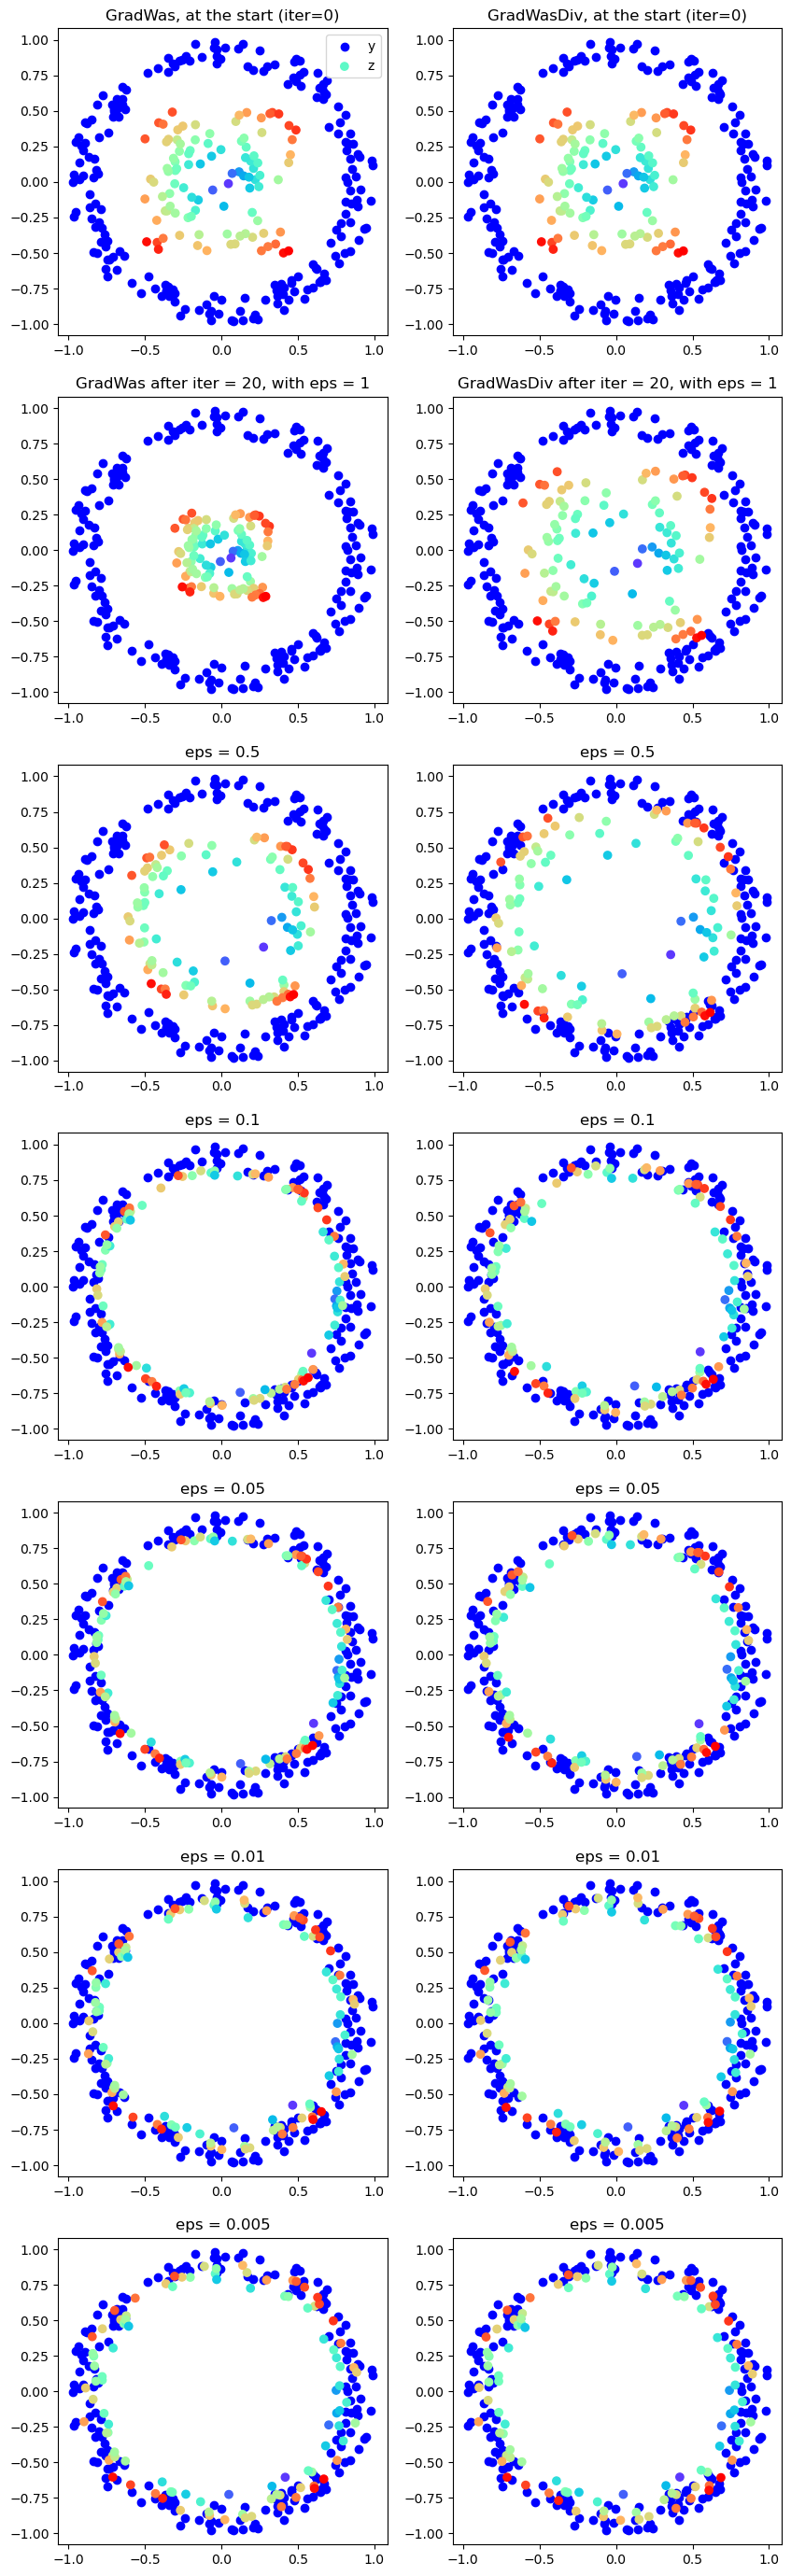

In [28]:
# pretty color for points
norm = np.linalg.norm(z0, axis=0)
colors = plt.cm.rainbow(norm / np.max(norm))


#params
tau = 0.1
eps = [1, 0.5, 0.1, 0.05, 0.01, 0.005]

fig, axs = plt.subplots(len(eps)+1, 2, figsize=(10,5*(len(eps)+1)))

axs[0][0].set_title("GradWas, at the start (iter=0)")
axs[0][0].scatter(y[0,:], y[1,:], c='blue', label="y")
axs[0][0].scatter(z0[0,:], z0[1,:], c = colors, label="z")
axs[0][0].legend()

axs[0][1].set_title("GradWasDiv, at the start (iter=0)")
axs[0][1].scatter(y[0,:], y[1,:], c='blue', label="y")
axs[0][1].scatter(z0[0,:], z0[1,:], c = colors, label="z")

for i, e in enumerate(eps) :
    ax1 = axs[i+1][0]
    ax2 = axs[i+1][1]

    z1 = GradWas(z0, y, mu, nu, tau=tau, eps=e, iter=20, method="Sinkhorn2d")
    z2 = GradWasDiv(z0, y, mu, nu, tau=tau, eps=e, iter=20, method="Sinkhorn2d")

    if i == 0 :
        ax1.set_title("GradWas after iter = 20, with eps = {}".format(e))
        ax2.set_title("GradWasDiv after iter = 20, with eps = {}".format(e))
    else :
        ax1.set_title("eps = {}".format(e))
        ax2.set_title("eps = {}".format(e))

    ax1.scatter(y[0,:], y[1,:], c='blue')
    ax1.scatter(z1[0,:], z1[1,:], c = colors)

    ax2.scatter(y[0,:], y[1,:], c='blue')
    ax2.scatter(z2[0,:], z2[1,:], c = colors)


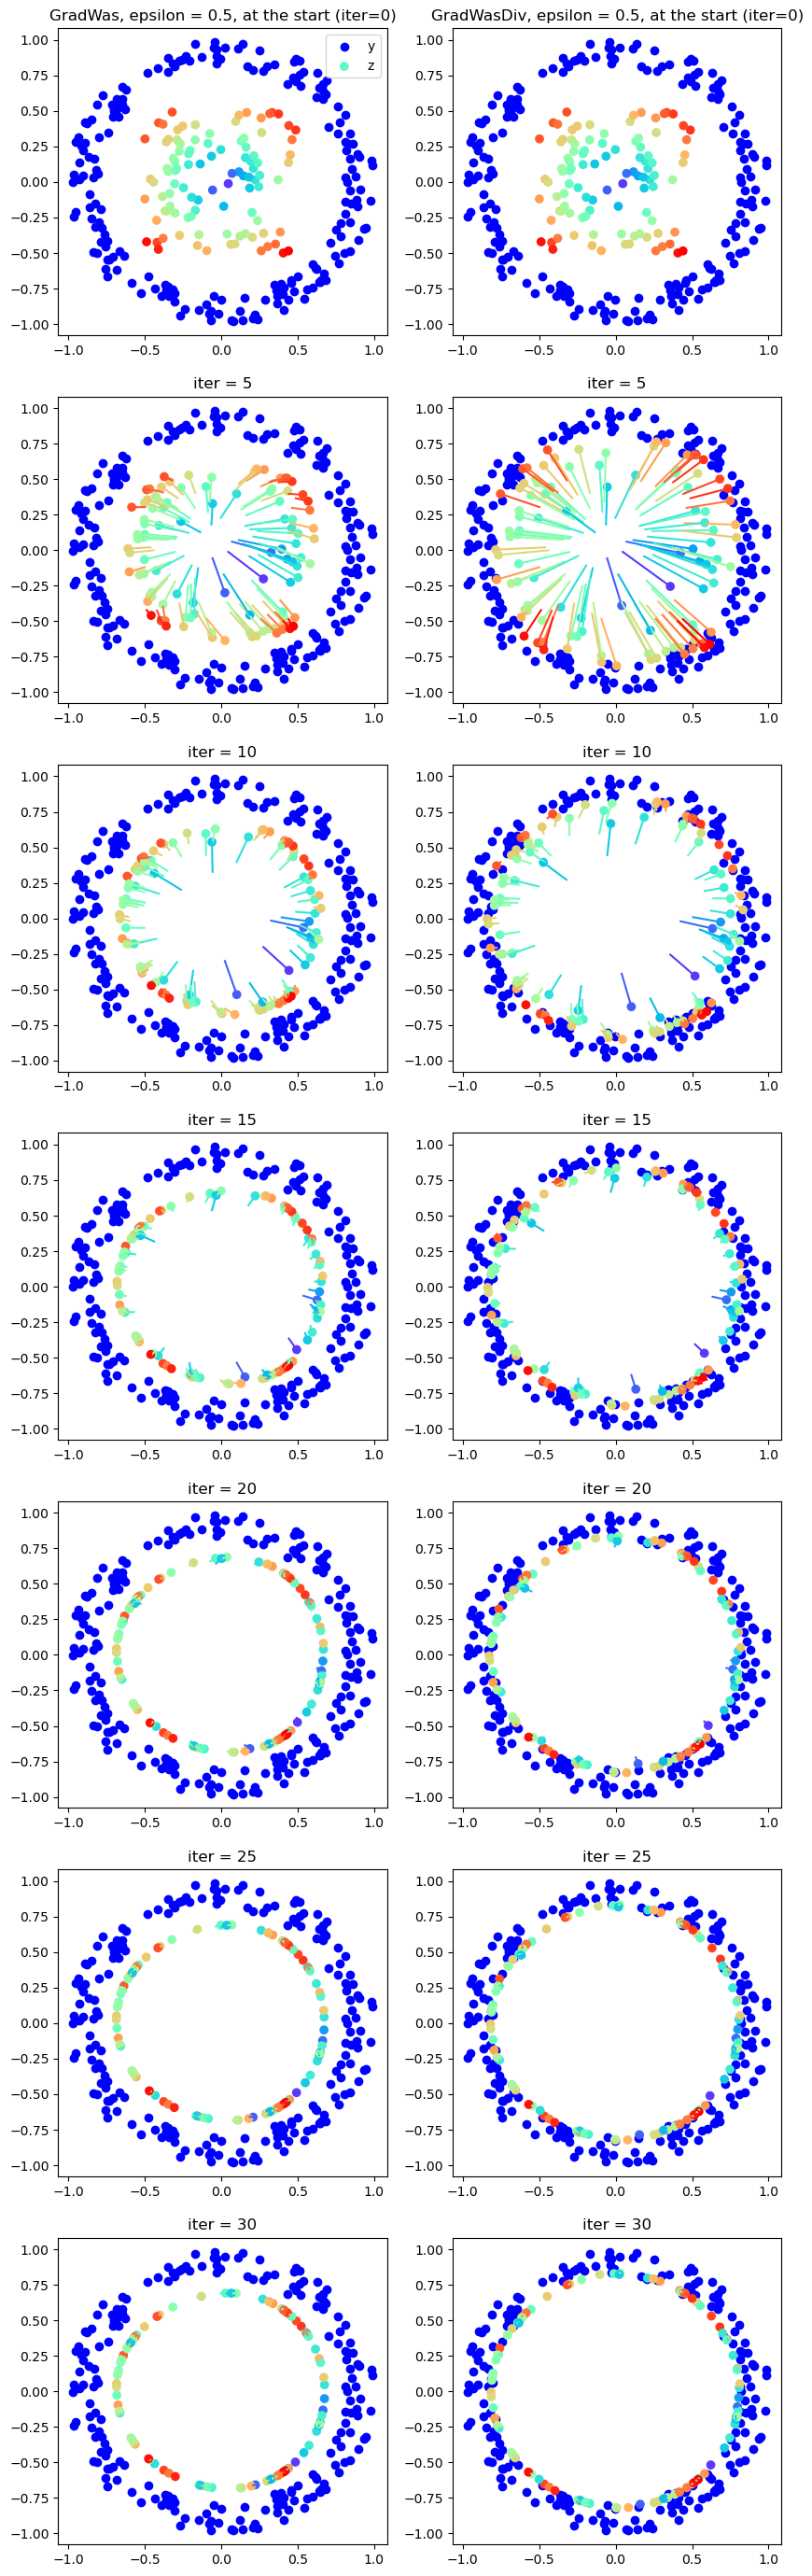

In [29]:
# pretty color for points
norm = np.linalg.norm(z0, axis=0)
colors = plt.cm.rainbow(norm / np.max(norm))


#params
nb_pas = 6
tau = 0.1
eps = 0.5


fig, axs = plt.subplots(nb_pas+1, 2, figsize=(10,5*(nb_pas+1)))

axs[0][0].set_title("GradWas, epsilon = {}, at the start (iter=0)".format(eps))
axs[0][0].scatter(y[0,:], y[1,:], c='blue', label="y")
axs[0][0].scatter(z0[0,:], z0[1,:], c = colors, label="z")
axs[0][0].legend()

axs[0][1].set_title("GradWasDiv, epsilon = {}, at the start (iter=0)".format(eps))
axs[0][1].scatter(y[0,:], y[1,:], c='blue', label="y")
axs[0][1].scatter(z0[0,:], z0[1,:], c = colors, label="z")

z1_old = z0
z2_old = z0
for i in range(1, nb_pas+1) :
    ax1 = axs[i][0]
    ax2 = axs[i][1]

    z1 = GradWas(z1_old, y, mu, nu, tau=tau, eps=eps, iter=20, method="Sinkhorn2d")
    z2 = GradWasDiv(z2_old, y, mu, nu, tau=tau, eps=eps, iter=20, method="Sinkhorn2d")

    ax1.set_title("iter = {}".format(i*5))
    ax2.set_title("iter = {}".format(i*5))

    ax1.scatter(y[0,:], y[1,:], c='blue')
    ax1.scatter(z1[0,:], z1[1,:], c = colors)

    ax2.scatter(y[0,:], y[1,:], c='blue')
    ax2.scatter(z2[0,:], z2[1,:], c = colors)

    for i in range(n) :
        ax1.plot([z1_old[0, i], z1[0,i]], [z1_old[1, i], z1[1,i]], color=colors[i])
        ax2.plot([z2_old[0, i], z2[0,i]], [z2_old[1, i], z2[1,i]], color=colors[i])
    
    z1_old = z1
    z2_old = z2
